# Occluded only result justification

Our reported performance on the occluded only joints is lower than the general error.
This may come across as counterintuitive, however, this notebook shows that the result we obtained is justified when the distribution of occlusion and errors of the more frequently occluded joints is considered.

In [1]:
import wandb

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from propose.poses.human36m import Human36mPose
from propose.datasets.human36m.Human36mDataset import Human36mDataset

api = wandb.Api()

In [2]:
from typing import Any, Dict


def unflatten(
    d: Dict[str, Any],
    base: Dict[str, Any] = None,
) -> Dict[str, Any]:
    """Convert any keys containing dotted paths to nested dicts

    >>> unflatten({'a': 12, 'b': 13, 'c': 14})  # no expansion
    {'a': 12, 'b': 13, 'c': 14}

    >>> unflatten({'a.b.c': 12})  # dotted path expansion
    {'a': {'b': {'c': 12}}}

    >>> unflatten({'a.b.c': 12, 'a': {'b.d': 13}})  # merging
    {'a': {'b': {'c': 12, 'd': 13}}}

    >>> unflatten({'a.b': 12, 'a': {'b': 13}})  # insertion-order overwrites
    {'a': {'b': 13}}

    >>> unflatten({'a': {}})  # insertion-order overwrites
    {'a': {}}
    """
    if base is None:
      base = {}

    for key, value in d.items():
        root = base

        ###
        # If a dotted path is encountered, create nested dicts for all but
        # the last level, then change root to that last level, and key to
        # the final key in the path.
        #
        # This allows one final setitem at the bottom of the loop.
        #
        if '.' in key:
            *parts, key = key.split('.')

            for part in parts:
                root.setdefault(part, {})
                root = root[part]

        if isinstance(value, dict):
            value = unflatten(value, root.get(key, {}))

        root[key] = value

    return base

In [3]:
run = api.run('ppierzc/propose_human36m/23ooc84a')

In [5]:
hist = run.history(pandas=False)

In [8]:
data = unflatten(hist[0])

In [10]:
pose = Human36mPose(np.zeros((16, 2)))
marker_names = pose.marker_names[1:]
del marker_names[8]

In [13]:
test_dataset = Human36mDataset(
    dirname="/data/human36m/processed",
    mpii=True,
    use_variance=True,
    occlusion_fractions=[],
    test=True,
)

Preparing test dataset: 100%|██████████| 24191/24191 [00:16<00:00, 1446.07it/s]


In [ ]:
occlusion_df = pd.DataFrame(occlusions, columns=['frequency'], index=marker_names).reset_index()

In [ ]:
df_occluded = pd.DataFrame(
        data['occluded']
)

df_not_occluded = pd.DataFrame(
    data['not_occluded']
)

In [69]:
df = (
    pd.concat(
        [df_not_occluded[marker_names], df_occluded[marker_names]], keys=["Not Occluded", "Occluded"], axis=1
    )
    .stack()
    .stack()
    .to_frame()
    .reset_index()
)

In [ ]:
freqs = occlusions / occlusions.sum()

E_err_occl = 0
E_err_noccl = 0

for key in data['occluded']:
    mean_joint_error = np.mean(list(filter(lambda x: x, data['occluded'][key])))
    E_err_occl += freqs[marker_names.index(key)] * mean_joint_error

for key in data['not_occluded']:
    mean_joint_error = np.mean(list(filter(lambda x: x, data['not_occluded'][key])))
    E_err_occl += freqs[marker_names.index(key)] * mean_joint_error

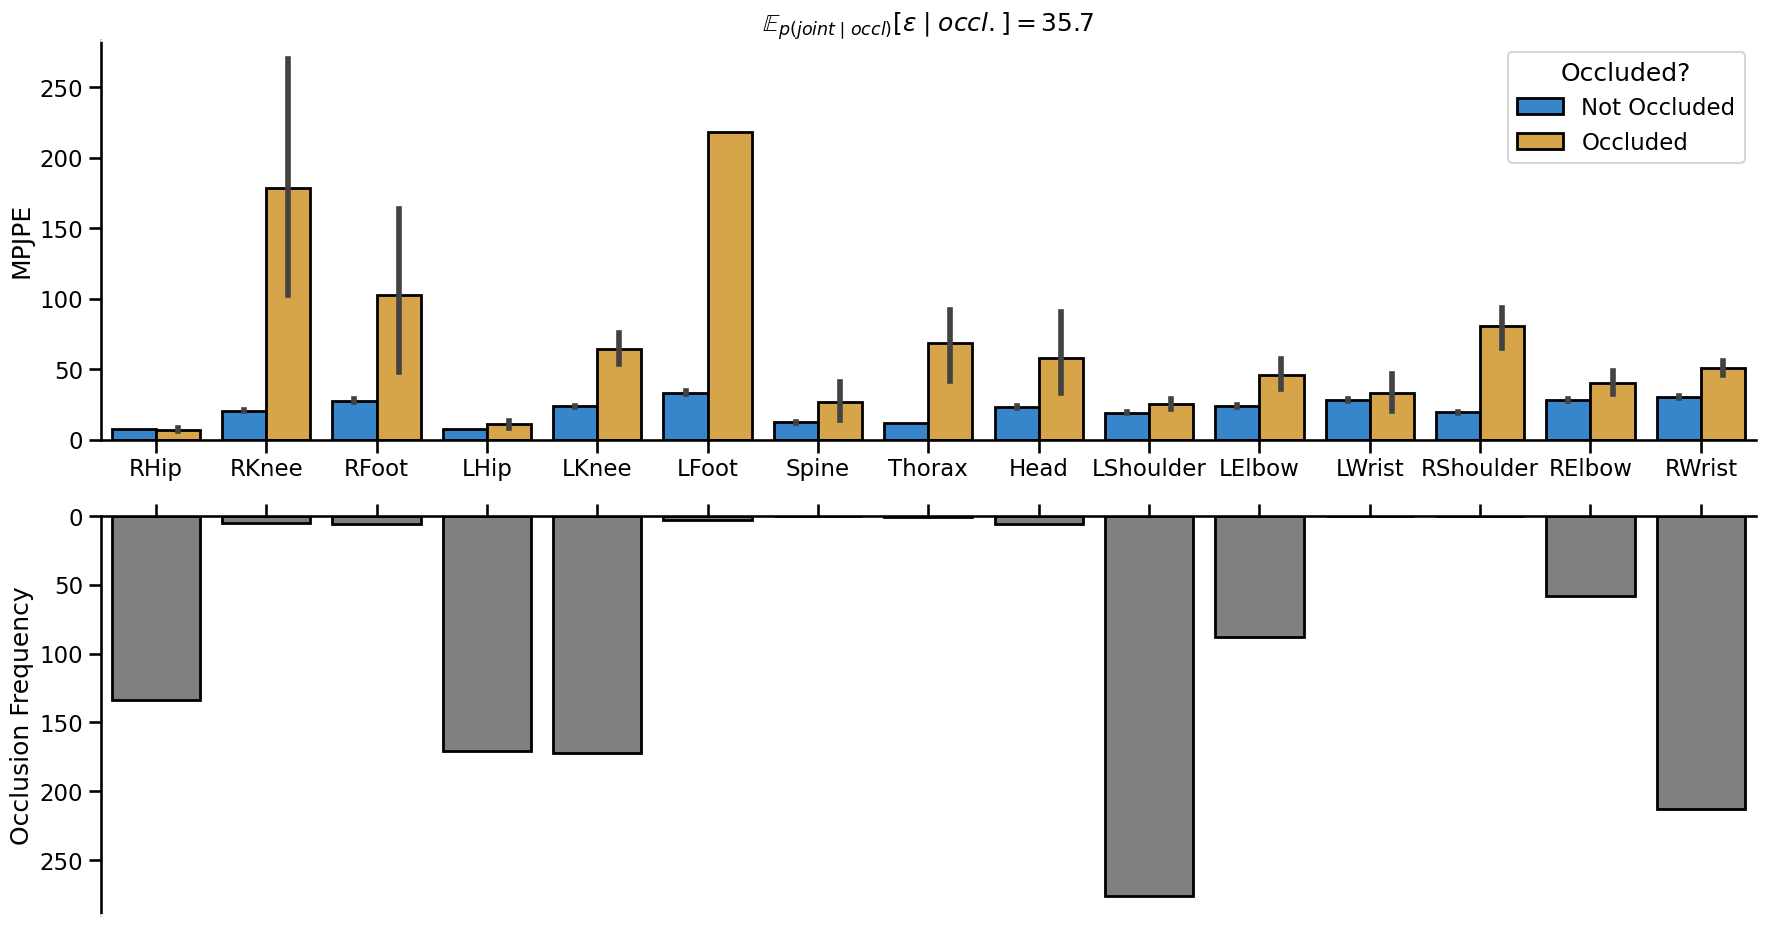

In [107]:
sns.set_context('talk')

plt.figure(figsize=(18, 10))
plt.subplot(2, 1, 1)
sns.barplot(data=df, x="level_1", y=0, hue="level_2", palette=["#1E88E5", "#EDAC32"], edgecolor='k', linewidth=2)
plt.xticks(None)
plt.ylabel("MPJPE")
plt.xlabel("")
plt.legend(title="Occluded?")
plt.gca().spines['top'].set_color('w')
plt.gca().spines['bottom'].set_color('k')
plt.gca().spines['right'].set_color('w')

plt.subplot(2, 1, 2)
sns.barplot(data=occlusion_df, x='index', y='frequency', color="gray", edgecolor='k', linewidth=2)
plt.xticks(rotation=0)
plt.gca().invert_yaxis()
plt.ylabel("Occlusion Frequency")
plt.xlabel("")
# plt.xticks([], [])
plt.tight_layout()

plt.gca().spines['top'].set_color('k')
plt.gca().spines['bottom'].set_color('w')
plt.gca().spines['right'].set_color('w')

plt.gca().xaxis.set_ticks_position('top')
plt.gca().xaxis.set_label_position('top')
plt.gca().set_xticklabels([])

plt.show()

In [102]:
score = 0
for key in data['occluded']:
    mean_joint_error = np.mean(list(filter(lambda x: x, data['occluded'][key])))
    score += freqs[marker_names.index(key)] * mean_joint_error
score

35.74222566777311

In [101]:
score = 0
for key in data['not_occluded']:
    mean_joint_error = np.mean(list(filter(lambda x: x, data['not_occluded'][key])))
    score += freqs[marker_names.index(key)] * mean_joint_error
score

19.659107235190973

In [104]:
score = 0
for key in data['occluded']:
    mean_joint_error = np.mean(list(filter(lambda x: x, data['occluded'][key])))
    score += mean_joint_error / len(marker_names)
score

67.46083859160723

In [106]:
score = 0
for key in data['not_occluded']:
    mean_joint_error = np.mean(list(filter(lambda x: x, data['not_occluded'][key])))
    score += mean_joint_error / len(marker_names)
score

21.027287777962947